In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif', size = 18)

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

from fxpmath import Fxp

import funcs
import importlib
importlib.reload(funcs)  # Importing the latest version of funcs.py

<module 'funcs' from '/home/urosminoski/Desktop/FAKS/MASTER/All-Digital-RF-Transmitter-in-FPGA-master-/sim/v1.4/python/jupyter/funcs.py'>

In [109]:
# Filter coefficients
b = [3.19382974, -8.02002256, 8.73762976, -4.61756997, 0.97458298]
a = [1, -1.63632004, 1.47600867, -0.75840147, 0.2125798, -0.02541702]

N = 1024
F1 = 0.1
F2 = 0.43

n_int = 4
n_frac = 8

ds_int = 12
ds_frac = 0

# Define fixed-point format for the input/output (single precision)
fxp_type = {
    'signed': True, 
    'n_word': n_int + n_frac, 
    'n_frac': n_frac, 
    'overflow': 'saturate', 
    'rounding': 'around'
}
# Define fixed-point format for intermediate calculations (double precision)
fxp_double_type = {
    'signed': True, 
    'n_word': 2 * (n_int + n_frac), 
    'n_frac': 2 * n_frac, 
    'overflow': 'saturate', 
    'rounding': 'trunc'
}
# Define fixed-point format for output of delta-sigma modulation
fxp_ds_type = {
    'signed': True, 
    'n_word': ds_int + ds_frac, 
    'n_frac': ds_frac, 
    'overflow': 'saturate', 
    'rounding': 'trunc'
}

In [91]:
# Decompos IIR filter to parallel IIR sections
[b_parallel, a_parallel] = funcs.decompose_iir_to_parallel(b, a)

print("Section 1:")
print("\tb =", b)
print("\ta =", a, '\n\n')

print("Parallel Decomposition:")
for i in range(len(a_parallel)):
    print("Section " + str(i+1) + ":")
    print("\tb =", b_parallel[i])
    print("\ta =", a_parallel[i], "\n")

Section 1:
	b = [3.19382974, -8.02002256, 8.73762976, -4.61756997, 0.97458298]
	a = [1, -1.63632004, 1.47600867, -0.75840147, 0.2125798, -0.02541702] 


Parallel Decomposition:
Section 1:
	b = [7.376738447284568]
	a = [1, -0.3466037644977315] 

Section 2:
	b = [0.42386913756811406, -2.782525031028174]
	a = [1, -0.6659138380831608, 0.1626025786310818] 

Section 3:
	b = [-4.606777844852687, 0.023283687418655274]
	a = [1, -0.623802437419108, 0.45098689983844903] 



In [92]:
# Convert the numerator (b) and denominator (a) coefficients to fixed-point format
b_fxp = [Fxp(val, **fxp_type) for val in b]
a_fxp = [Fxp(val, **fxp_type) for val in a]
# Convert 2D arrays of numerator (b) and denominator (a) coefficients to fixed-point format
b_parallel_fxp = [[Fxp(val, **fxp_type) for val in row] for row in b_parallel]
a_parallel_fxp = [[Fxp(val, **fxp_type) for val in row] for row in a_parallel]

print("Section 1:")
print("\tb =", [val.get_val() for val in b_fxp])
print("\ta =", [val.get_val() for val in a_fxp], '\n\n')

print("Parallel Decomposition:")
for i in range(len(a_parallel_fxp)):
    print("Section " + str(i+1) + ":")
    print("\tb =", [val.get_val() for val in b_parallel_fxp[i]])
    print("\ta =", [val.get_val() for val in a_parallel_fxp[i]], "\n")

Section 1:
	b = [3.1953125, -8.0, 7.99609375, -4.6171875, 0.97265625]
	a = [1.0, -1.63671875, 1.4765625, -0.7578125, 0.2109375, -0.02734375] 


Parallel Decomposition:
Section 1:
	b = [7.375]
	a = [1.0, -0.34765625] 

Section 2:
	b = [0.42578125, -2.78125]
	a = [1.0, -0.6640625, 0.1640625] 

Section 3:
	b = [-4.60546875, 0.0234375]
	a = [1.0, -0.625, 0.44921875] 



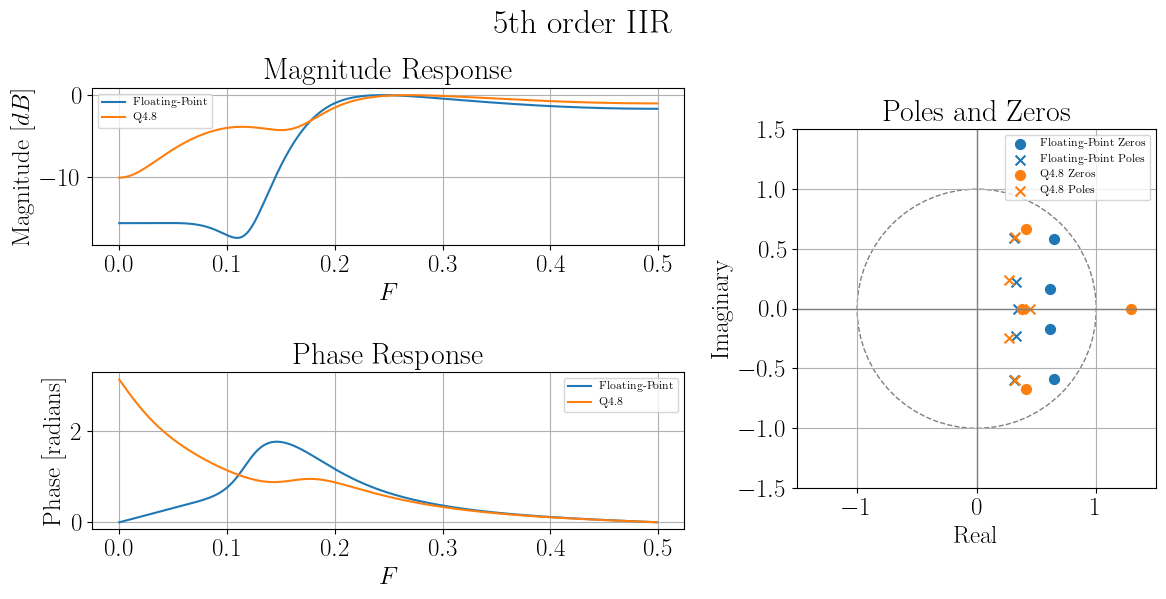

In [93]:
data_pz = [(b, a), ([val.get_val() for val in b_fxp], [val.get_val() for val in a_fxp])]
funcs.plot_IIR_and_zeros_poles(data_pz, labels=["Floating-Point", "Q4.8"], fig_title="5th order IIR")

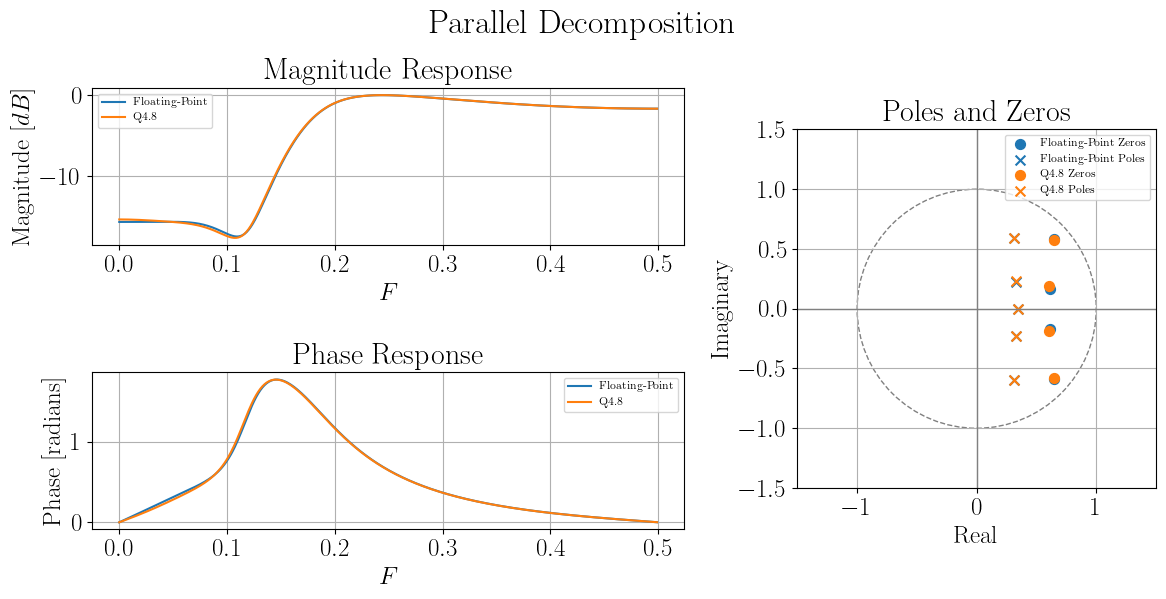

In [94]:
# Combine Parallel Sections
b_comb_fxp, a_comb_fxp = funcs.combine_parallel_sections([[val.get_val() for val in row] for row in b_parallel_fxp], [[val.get_val() for val in row] for row in a_parallel_fxp])
data_pz = [(b, a), (b_comb_fxp, a_comb_fxp)]
funcs.plot_IIR_and_zeros_poles(data_pz, labels=["Floating-Point", "Q4.8"], fig_title="Parallel Decomposition")

In [95]:
x = np.sin(2*np.pi*F1*np.arange(N)) + np.sin(2*np.pi*F2*np.arange(N))
x /= np.max(x)

y_ = signal.lfilter(b, a, x)
y = funcs.parallel_lfilter_fxp(b_parallel, a_parallel, x, n_int, n_frac)

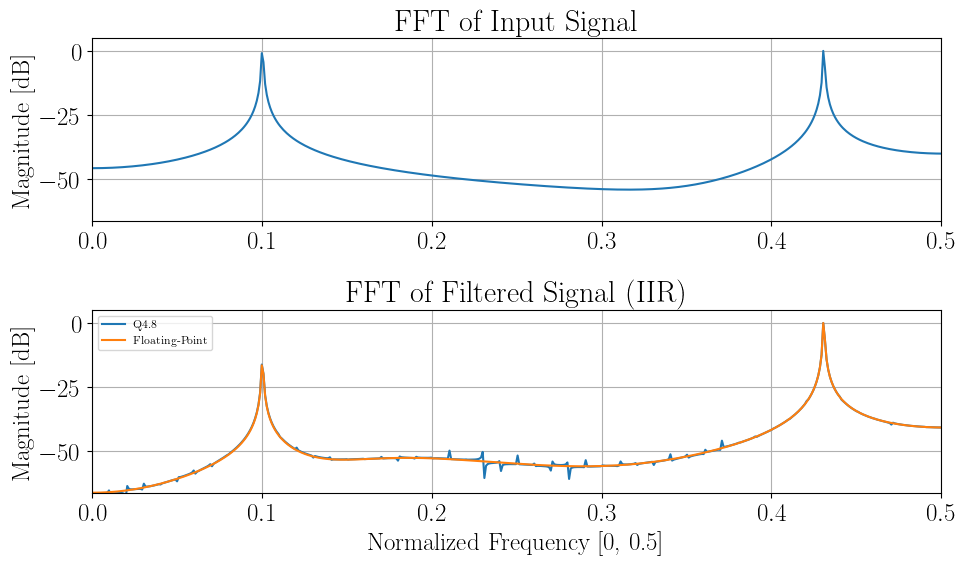

In [96]:
funcs.plot_fft_dB(x, [y, y_], title1="FFT of Input Signal", title2="FFT of Filtered Signal (IIR)", legend2=["Q4.8", "Floating-Point"])

In [97]:
M = 4
OSR = 8
x = 2**(4-1)*np.sin(2*np.pi*np.floor(2/7*N/OSR)*np.arange(N)/N)

a_parallel_fxp

[[fxp-s12/8(1.0), fxp-s12/8(-0.34765625)],
 [fxp-s12/8(1.0), fxp-s12/8(-0.6640625), fxp-s12/8(0.1640625)],
 [fxp-s12/8(1.0), fxp-s12/8(-0.625), fxp-s12/8(0.44921875)]]

In [98]:
y0 = Fxp(0, **fxp_double_type)
y0d = Fxp(0, **fxp_double_type)

y1 = Fxp(0, **fxp_double_type)
w1 = Fxp(0, **fxp_double_type)
w1d = Fxp(0, **fxp_double_type)
w1dd = Fxp(0, **fxp_double_type)

y2 = Fxp(0, **fxp_double_type)
w2 = Fxp(0, **fxp_double_type)
w2d = Fxp(0, **fxp_double_type)
w2dd = Fxp(0, **fxp_double_type)

x_fxp = Fxp(0, **fxp_type)
x_double_fxp = Fxp(0, **fxp_double_type)

yi = Fxp(0, **fxp_double_type)
yiir = Fxp(0, **fxp_double_type)
e = Fxp(0, **fxp_double_type)
v = Fxp(0, **fxp_ds_type)
v_tmp = Fxp(0, **fxp_double_type)

b_double = [[Fxp(val.get_val(), **fxp_double_type) for val in row] for row in b_parallel_fxp]
a_double = [[Fxp(val.get_val(), **fxp_double_type) for val in row] for row in a_parallel_fxp]

y = np.zeros(len(x))

# [[fxp-s12/8(7.375)],
#  [fxp-s12/8(0.42578125), fxp-s12/8(-2.78125)],
#  [fxp-s12/8(-4.60546875), fxp-s12/8(0.0234375)]]

# [[fxp-s12/8(1.0), fxp-s12/8(-0.34765625)],
#  [fxp-s12/8(1.0), fxp-s12/8(-0.6640625), fxp-s12/8(0.1640625)],
#  [fxp-s12/8(1.0), fxp-s12/8(-0.625), fxp-s12/8(0.44921875)]]

for n in range(len(x)):
    # Load the input sample into x_fxp
    x_fxp(x[n])
    
    # Compute the intermediate sum
    yi( (yiir + x_fxp)() )
    v( yi() )     # Update v based on yi

    # Quantization error
    e( (yi - v)() )

    # First section (H0)
    y0( (b_double[0][0] * e - a_double[0][1] * y0d)() )
    # print("y0 = ", y0.get_val())

    # Second section (H1)
    w1( (e - a_double[1][1] * w1d - a_double[1][2] * w1dd)() )
    y1( (b_double[1][0] * w1 + b_double[1][1] * w1d)() )
    # print("w1 = ", w1.get_val())
    # print("y1 = ", y1.get_val())

    # Third section (H2)
    w2( (e - a_double[2][1] * w2d - a_double[2][2] * w2dd)() )
    y2( (b_double[2][0] * w1 + b_double[2][1] * w2d)() )
    # print("w2 = ", w2.get_val())
    # print("y2 = ", y2.get_val())

    # Final IIR output
    yiir( (y0 + y1 + y2)() )
    # print("yiir = ", yiir.get_val())

    # print("y0d = ", y0d.get_val())
    # print("w1dd = ", w1dd.get_val())
    # print("w1d = ", w1d.get_val())
    # print("w2dd = ", w2dd.get_val())
    # print("w2d = ", w2d.get_val())

    # Shift the intermediate terms for the next iteration
    y0d( y0() )
    w1dd( w1d() ) 
    w1d( w1() )
    w2dd( w2d() )
    w2d( w2() )

    # The output at this stage (v) corresponds to the quantized value in VHDL
    # You can assign it to an output or use it as needed
    y[n] = v()

/tmp/ipykernel_4068/2845838153.py:2: RuntimeWarning: divide by zero encountered in log10
  y_fft_dB = 20*np.log10(np.abs(y_fft))


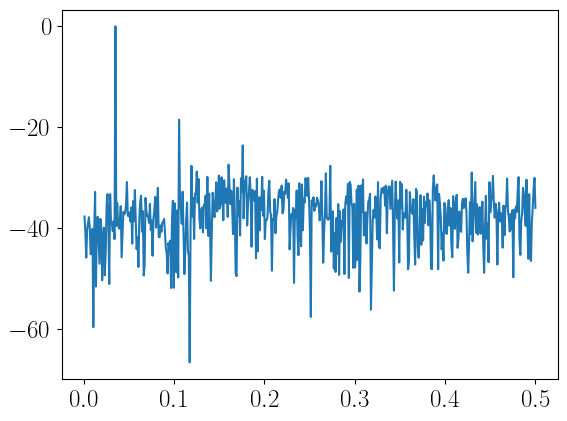

In [99]:
y_fft = np.fft.fft(y)
y_fft_dB = 20*np.log10(np.abs(y_fft))
y_fft_dB -= np.max(y_fft_dB)
y_fft_dB = y_fft_dB[:len(x)//2]
freqs = np.linspace(0, 0.5, len(x)//2)

plt.plot(freqs, y_fft_dB)
# plt.plot(y)

In [100]:
x_fxp = Fxp(0, **fxp_type)
a = Fxp(0, **fxp_double_type)
b = Fxp(0, **fxp_double_type)
c = Fxp(0, **fxp_double_type)
d = Fxp(0, **fxp_double_type)

print(x_fxp.info(verbose=3))
print(a.info(verbose=3))

x_fxp( x[10] )
a( 2.10234252 )
b( 0.23123345 )
c( -1.1234455 )
d( -3.1202511 )

d( (x_fxp*a + b*c)() )
print(d.info(verbose=3))

	dtype		=	fxp-s12/8
	Value		=	0.0

	Signed		=	True
	Word bits	=	12
	Fract bits	=	8
	Int bits	=	3
	Val data type	=	<class 'float'>

	Upper		=	7.99609375
	Lower		=	-8.0
	Precision	=	0.00390625
	Overflow	=	saturate
	Rounding	=	around
	Shifting	=	expand

None
	dtype		=	fxp-s24/16
	Value		=	0.0

	Signed		=	True
	Word bits	=	24
	Fract bits	=	16
	Int bits	=	7
	Val data type	=	<class 'float'>

	Upper		=	127.99998474121094
	Lower		=	-128.0
	Precision	=	1.52587890625e-05
	Overflow	=	saturate
	Rounding	=	trunc
	Shifting	=	expand

None
	dtype		=	fxp-s24/16
	Value		=	13.249404907226562
	inaccuracy	=	True

	Signed		=	True
	Word bits	=	24
	Fract bits	=	16
	Int bits	=	7
	Val data type	=	<class 'numpy.float64'>

	Upper		=	127.99998474121094
	Lower		=	-128.0
	Precision	=	1.52587890625e-05
	Overflow	=	saturate
	Rounding	=	trunc
	Shifting	=	expand

None


In [168]:
n_int = 5
n_frac = 20
fxp_type = {
    'signed': True, 
    'n_word': n_int + n_frac, 
    'n_frac': n_frac, 
    'overflow': 'saturate', 
    'rounding': 'around'
}

n_int = 5
n_frac = 50
double_fxp_type = {
    'signed': True, 
    'n_word': n_int + n_frac, 
    'n_frac': n_frac, 
    'overflow': 'saturate', 
    'rounding': 'around'
}

n_int = 5
n_frac = 0
out_fxp_type = {
    'signed': True, 
    'n_word': n_int + n_frac, 
    'n_frac': n_frac, 
    'overflow': 'saturate', 
    'rounding': 'around'
}

In [169]:
b00 = Fxp(7.3765809, signed=True, n_word=12, n_frac=8, overflow='saturate', rounding='around')
a01 = Fxp(-0.3466036, signed=True, n_word=12, n_frac=11, overflow='saturate', rounding='around')

b10 = Fxp(0.424071040, signed=True, n_word=12, n_frac=11, overflow='saturate', rounding='around')
b11 = Fxp(-2.782608716, signed=True, n_word=12, n_frac=9, overflow='saturate', rounding='around')
a11 = Fxp(-0.66591402, signed=True, n_word=12, n_frac=11, overflow='saturate', rounding='around')
a12 = Fxp(0.16260264, signed=True, n_word=12, n_frac=11, overflow='saturate', rounding='around')

b20 = Fxp(-4.606822182, signed=True, n_word=12, n_frac=8, overflow='saturate', rounding='around')
b21 = Fxp(0.023331537, signed=True, n_word=12, n_frac=11, overflow='saturate', rounding='around')
a21 = Fxp(0.62380242, signed=True, n_word=12, n_frac=11, overflow='saturate', rounding='around')
a22 = Fxp(0.4509869, signed=True, n_word=12, n_frac=11, overflow='saturate', rounding='around')

In [170]:
print(b_parallel_fxp)
print(a_parallel_fxp)

[[fxp-s12/8(7.375)], [fxp-s12/8(0.42578125), fxp-s12/8(-2.78125)], [fxp-s12/8(-4.60546875), fxp-s12/8(0.0234375)]]
[[fxp-s12/8(1.0), fxp-s12/8(-0.34765625)], [fxp-s12/8(1.0), fxp-s12/8(-0.6640625), fxp-s12/8(0.1640625)], [fxp-s12/8(1.0), fxp-s12/8(-0.625), fxp-s12/8(0.44921875)]]


In [186]:
x_fxp = Fxp(0, **fxp_type)
e = Fxp(0, **double_fxp_type)
yi = Fxp(0, **double_fxp_type)
v = Fxp(0, **out_fxp_type)

y0 = Fxp(0, **double_fxp_type)
y0d = Fxp(0, **double_fxp_type)
y1 = Fxp(0, **double_fxp_type)
w1 = Fxp(0, **double_fxp_type)
w1d = Fxp(0, **double_fxp_type)
w1dd = Fxp(0, **double_fxp_type)
y2 = Fxp(0, **double_fxp_type)
w2 = Fxp(0, **double_fxp_type)
w2d = Fxp(0, **double_fxp_type)
w2dd = Fxp(0, **double_fxp_type)
yiir = Fxp(0, **double_fxp_type)

M = 4
OSR = 8
x = 2**(5-1)*np.sin(2*np.pi*np.floor(2/7*N/OSR)*np.arange(N)/N)
y = np.zeros(len(x))

ee = []

for n in range(len(x)):
    x_fxp( x[n] )
    
    yi( (x_fxp+yiir)() )
    # print("x_fxp = ", x_fxp())
    # print("yiir = ", yiir())
    
    v( yi() )
    if(v()%2==0):
        v( (v+1)() )
    e( (yi-v)() )

    ee.append(e())

    # print("e = ", e())
    # print('')
    
    # First section (H0)
    y0( (b00*e + a01*y0d)() )
    # Second section (H1)
    w1( (e - a11*w1d - a12*w1dd)() )
    y1( (b10*w1 + b11*w1d)() )
    # Third section (H2)
    w2( (e - a21*w2d - a22*w2dd)() )
    y2( (b20*w1 + b21*w2d)() )
    # Final IIR output
    yiir( (y0 + y1 + y2)() )

    y0d( y0() )
    w1dd( w1d() )
    w1d( w1() )
    w2dd( w2d() )
    w2d( w2() )
    
    y[n] = v()

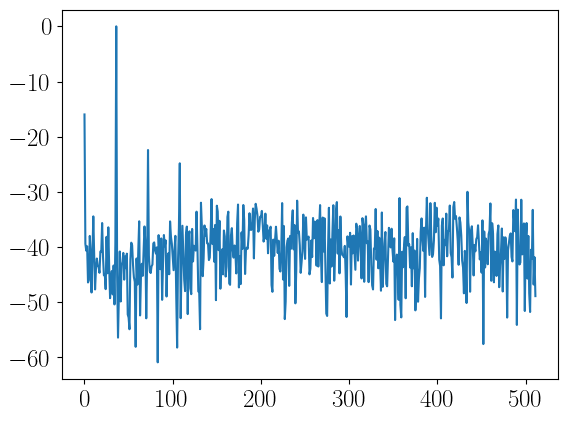

In [187]:
ee_fft = np.fft.fft(ee)
ee_fft_dB = 20*np.log10(np.abs(ee_fft))
ee_fft_dB -= np.max(ee_fft_dB)
ee_fft_dB = y_fft_dB[:len(x)//2]

plt.plot(ee_fft_dB)

[ 1.  1.  9. ... -9. -7. -3.]


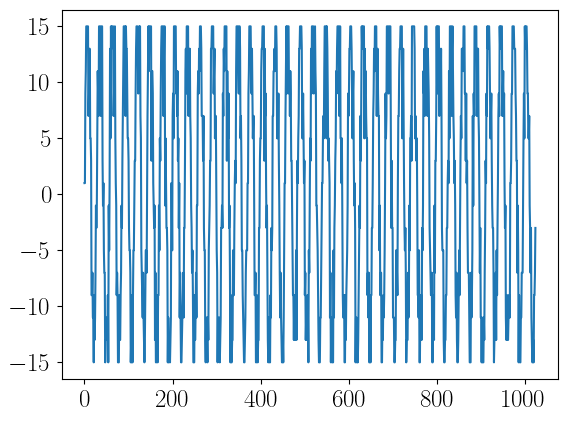

In [172]:
plt.plot(y)
print(y)

In [157]:
b = [3.1953125, -8.0, 7.99609375, -4.6171875, 0.97265625]
a = [1.0, -1.63671875, 1.4765625, -0.7578125, 0.2109375, -0.02734375] 

y_ = signal.lfilter(b, a, x)

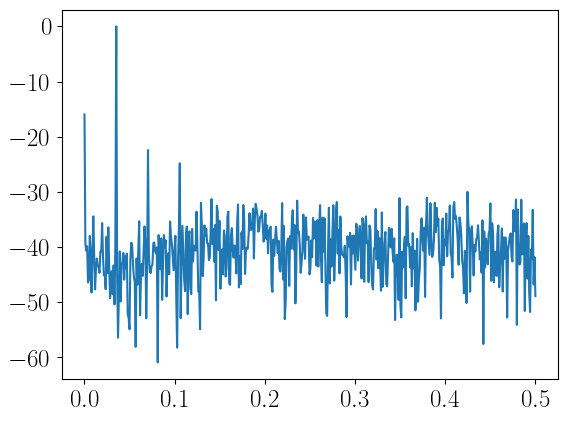

In [173]:
y_fft = np.fft.fft(y)
y_fft_dB = 20*np.log10(np.abs(y_fft))
y_fft_dB -= np.max(y_fft_dB)
y_fft_dB = y_fft_dB[:len(x)//2]

y_fft_ = np.fft.fft(y_)
y_fft_dB_ = 20*np.log10(np.abs(y_fft_))
y_fft_dB_ -= np.max(y_fft_dB_)
y_fft_dB_ = y_fft_dB_[:len(x)//2]

freqs = np.linspace(0, 0.5, len(x)//2)

plt.plot(freqs, y_fft_dB)
# plt.plot(freqs, y_fft_dB_)

/tmp/ipykernel_4068/684921837.py:4: RuntimeWarning: divide by zero encountered in log10
  x_fft_dB = 20*np.log10(np.abs(x_fft))


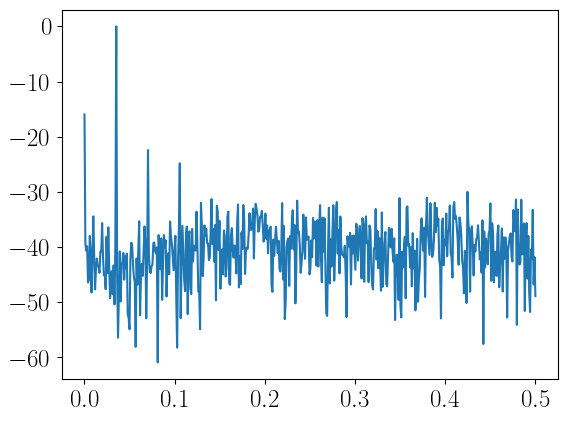

In [179]:
x_fxp_ = [Fxp(val, **out_fxp_type) for val in x]

x_fft = np.fft.fft(x_fxp_)
x_fft_dB = 20*np.log10(np.abs(x_fft))
x_fft_dB -= np.max(x_fft_dB)
x_fft_dB = x_fft_dB[:len(x)//2]

freqs = np.linspace(0, 0.5, len(x)//2)

plt.plot(freqs, y_fft_dB)

7.0


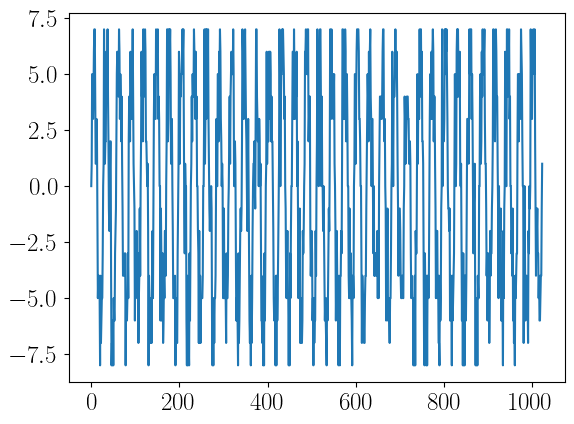

In [23]:
plt.plot(y)
print(np.max(y))

In [76]:
for i in range(len(y)):
    print(y[i])

0.0
1.0
5.0
5.0
3.0
4.0
7.0
6.0
7.0
7.0
3.0
3.0
2.0
2.0
-2.0
-6.0
-4.0
-3.0
-2.0
-6.0
-5.0
-5.0
-7.0
-6.0
-3.0
-2.0
-3.0
0.0
0.0
5.0
5.0
1.0
4.0
6.0
6.0
3.0
7.0
5.0
3.0
4.0
5.0
1.0
0.0
-8.0
-4.0
-1.0
-3.0
-5.0
-4.0
-7.0
-5.0
-8.0
-6.0
-2.0
-4.0
-1.0
0.0
1.0
5.0
2.0
6.0
2.0
7.0
6.0
5.0
7.0
6.0
4.0
2.0
1.0
0.0
-4.0
-3.0
-6.0
-1.0
-6.0
-4.0
-5.0
-6.0
-7.0
-6.0
-4.0
-4.0
0.0
-2.0
0.0
7.0
4.0
4.0
2.0
4.0
9.0
6.0
5.0
8.0
6.0
2.0
1.0
4.0
-1.0
-4.0
-2.0
-2.0
-6.0
-4.0
-7.0
-5.0
-4.0
-8.0
-4.0
-6.0
0.0
-2.0
-1.0
3.0
6.0
5.0
1.0
5.0
4.0
7.0
5.0
8.0
5.0
5.0
5.0
0.0
-1.0
-3.0
0.0
-4.0
-2.0
-5.0
-8.0
-4.0
-6.0
-6.0
-8.0
-4.0
-3.0
-1.0
1.0
3.0
3.0
2.0
5.0
4.0
6.0
7.0
7.0
7.0
4.0
6.0
1.0
2.0
2.0
-1.0
-4.0
-4.0
-7.0
-2.0
-5.0
-7.0
-6.0
-5.0
-6.0
-4.0
-2.0
-5.0
0.0
0.0
4.0
2.0
0.0
5.0
6.0
4.0
6.0
4.0
6.0
4.0
3.0
3.0
4.0
0.0
-5.0
-1.0
-1.0
-4.0
-5.0
-5.0
-7.0
-9.0
-6.0
-5.0
-5.0
-4.0
-4.0
0.0
0.0
3.0
4.0
4.0
5.0
5.0
7.0
6.0
5.0
7.0
5.0
5.0
2.0
1.0
-1.0
-4.0
-2.0
-3.0
-4.0
-7.0
-5.0
-8.0
-4.0
-7.0
-3.0
-

In [162]:
a = Fxp(2.12345112, **fxp_type)
b = Fxp(0, **fxp_ds_type)
print(a.info(verbose=3))
b(a.get_val())
print(b.info(verbose=3))

	dtype		=	fxp-s12/8
	Value		=	2.125
	inaccuracy	=	True

	Signed		=	True
	Word bits	=	12
	Fract bits	=	8
	Int bits	=	3
	Val data type	=	<class 'float'>

	Upper		=	7.99609375
	Lower		=	-8.0
	Precision	=	0.00390625
	Overflow	=	saturate
	Rounding	=	around
	Shifting	=	expand

None
	dtype		=	fxp-s5/0
	Value		=	2.0
	inaccuracy	=	True

	Signed		=	True
	Word bits	=	5
	Fract bits	=	0
	Int bits	=	4
	Val data type	=	<class 'numpy.float64'>

	Upper		=	15.0
	Lower		=	-16.0
	Precision	=	1.0
	Overflow	=	saturate
	Rounding	=	trunc
	Shifting	=	expand

None
